Developed notebook for plotting all corresponded figures that will be used in [XV 2018 Congreso Geologico Chileno](www.congresogeologicochileno.cl). All plot ilustrate: 
* Synthetic dike model
* Total field anomaly
* Cross-correlation & Full cross-correlation for synthetic data
* Location map of study area
* Observed magnetic anomaly 
* Cross-correlation & Full cross-correlation for real data


In [1]:
import numpy
from utm import from_latlon
from matplotlib import pyplot
from codes.grids import regular_grid
from codes.statistical import analysis
from scipy.interpolate import griddata
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# Loading the real data file
tf =  numpy.loadtxt('serradocabral_old.dat', skiprows = 1, usecols = (6), unpack=True)

In [3]:
# Define the shape data
shapedata = (37, 51)

In [4]:
# Gridding the data
latitude, longitude = regular_grid((-18.25, -16.5, -45.4, -43.5), shapedata)

In [5]:
# Create the empty lists and calculate the metric coordinates
xo = []
yo = []
for k in range(tf.size):
    kk = from_latlon(latitude[k], longitude[k])
    xo.append(kk[0])
    yo.append(kk[1])

In [6]:
# Convert to numpy array
xo = numpy.array(xo)
yo = numpy.array(yo)

In [7]:
# Saving the real data
data = numpy.vstack((xo, yo, longitude, latitude, tf)).T
numpy.savetxt('serradocabral.xyz', data, fmt = '%.3f', delimiter = ',')

# 1 Synthetic data

In [8]:
# Create the grid
area = (-4000., 4000., -4000., 4000.)
shape = (40, 40)
h = -150.
x, y, z = regular_grid(area, shape, h)

In [9]:
from codes.prism import prism_tf
from codes.plot import draw_prism

In [12]:
# Synthetic model
dikemodel = (-800., 800., -1000., 1000., 0., 3000., 1.5)

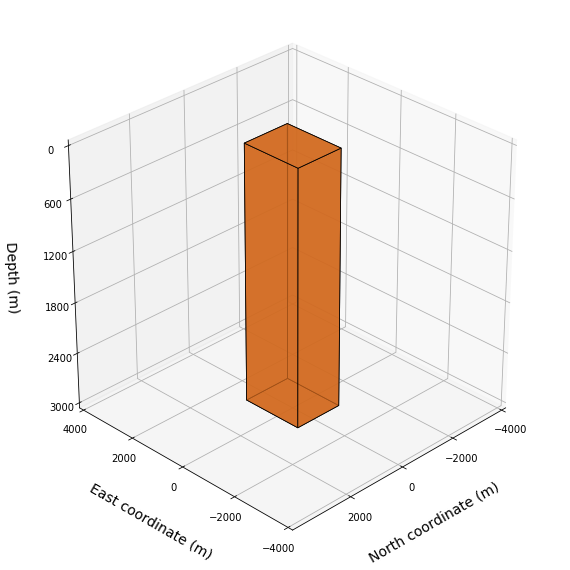

In [13]:
# Plot the synthetic model
figure = pyplot.figure(figsize=(8,8))
ax = figure.gca(projection = '3d')
x1, x2, y1, y2, z1, z2 = dikemodel[:6]
v = numpy.array([[x1, y1, z2], [x1, y2, z2], [x2, y2, z2], [x2, y1, z2], 
                 [x1, y1, z1], [x1, y2, z1], [x2, y2, z1], [x2, y1, z1]])
vertices = [[v[0],v[1],v[2],v[3]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]],
            [v[2],v[3],v[7],v[6]], [v[3],v[0],v[4],v[7]], [v[4],v[5],v[6],v[7]]]
# Plota os lados
pc = Poly3DCollection(vertices, alpha = 0.75, linewidths = 0.75, edgecolors = 'k')
pc.set_facecolor('chocolate')
ax.add_collection3d(pc)

x_scale = 1.
y_scale = 1.
z_scale = 1.
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj

ax.set_xlabel('North coordinate (m)', size = 14, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 14, labelpad = 20)
ax.set_zlabel('Depth (m)', size = 14, labelpad = 20)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(0., z2)
ax.set_xticks(numpy.arange(x.min(), x.max(), 2000))
ax.set_yticks(numpy.linspace(y.min(), y.max(), 5))
ax.set_zticks(numpy.linspace(0., z2, 6))
ax.view_init(210, 135)
pyplot.tight_layout(True)
pyplot.savefig('figure00.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure00.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [14]:
# Directions
incf, decf = -45., -45.
incs, decs = 35., 40.

In [15]:
# Calculate the total field anomaly
tfa = prism_tf(x, y, z, dikemodel, incf, decf, incs, decs)

In [16]:
from codes.auxiliars import addnoise
from codes.statistical import analysis

In [17]:
_ = analysis(tfa, 'nT')

Minimum:    -613.2955 nT
Maximum:    186.7053 nT
Mean value: -10.3767 nT
Variation:  800.0008 nT


In [18]:
# Add noise to the data
tfa = addnoise(tfa, 3, 0.1)

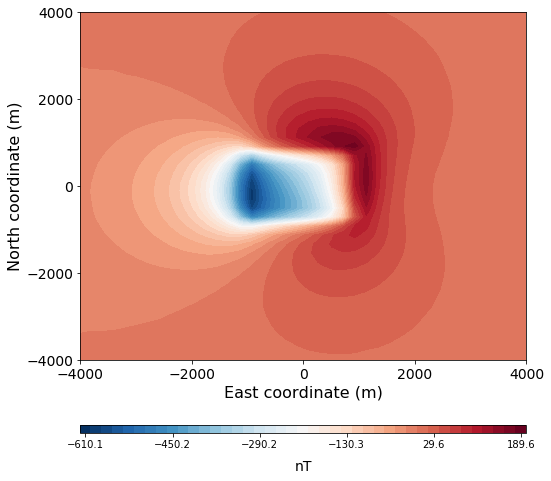

In [88]:
# Visualyzing the data plt
pyplot.close('all')
pyplot.figure(figsize=(8,8))
fig1 = pyplot.contourf(y.reshape(shape), x.reshape(shape), tfa.reshape(shape),
                       50, cmap = pyplot.cm.RdBu_r)
cbar1 = pyplot.colorbar(fig1, aspect = 60, fraction = 0.05, orientation = 'horizontal')
cbar1.set_label('nT', fontsize = 14, rotation = 0, labelpad = 10)
cbar1.set_ticks(numpy.linspace(tfa.min(), tfa.max(), 6))
cbar1.set_clim(tfa.min(), tfa.max())
pyplot.xlabel('East coordinate (m)', fontsize = 16)
pyplot.ylabel('North coordinate (m)', fontsize = 16)
pyplot.xticks(numpy.linspace(y.min(), y.max(), 5), fontsize = 14)
pyplot.yticks(numpy.linspace(x.min(), x.max(), 5), fontsize = 14)

pyplot.savefig('figure01-totalfield.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure01-totalfield.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [10]:
# Calculate the simple cross-correlation
from codes.statistical import cccoef
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv
from codes.equivalentlayer import layer, rtp_layer, fit_layer

### (A) Calculate by using Fourier domain only

In [21]:
# Create the vectors and the grid
inc = numpy.linspace(15., 90., 76)
dec = numpy.linspace(-90., 90., 181)
D, I = numpy.meshgrid(dec, inc)

In [22]:
# Create the zero matrix
res = numpy.zeros_like(D)

In [23]:
# Create the new shape data
xobs = x.reshape(shape)
yobs = y.reshape(shape)
zobs = z.reshape(shape)
dobs = tfa.reshape(shape)

In [11]:
from time import time

In [25]:
# Compute the calculation time
timei = time()
for k, d in enumerate(dec):
    for j, i in enumerate(inc):
        rtp = reduction(xobs, yobs, dobs, incf, decf, i, d)
        res[j,k] = cccoef(totalgrad(xobs, yobs, rtp),
                          zderiv(xobs, yobs, rtp))
timef = time()
print 'Calculation time: %.3f' % (timef - timei)        

codes/auxiliars.py:202: RuntimeWarning: invalid value encountered in divide
  theta = z + ((x*u + y*v)/k)*1j


Calculation time: 21.921


In [26]:
imax, jmax = numpy.where(res == res.max())
incmax = float(I[imax, jmax])
decmax = float(D[imax, jmax])
print 'Inclination:', incmax
print 'Declination:', decmax

Inclination: 34.0
Declination: 37.0


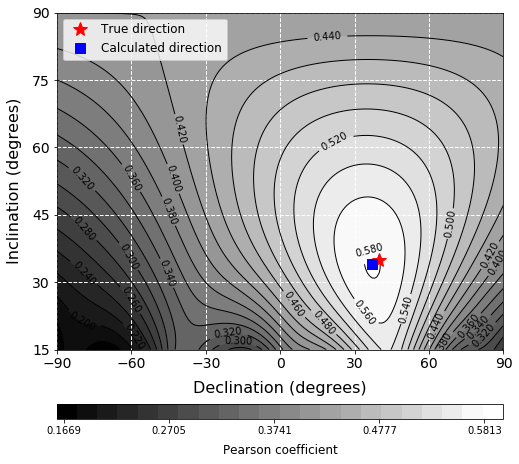

In [28]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 8))
c1 = pyplot.contour(D, I, res, 25, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 10)
c2 = pyplot.contourf(D, I, res, 25, vmin = res.min(), vmax = res.max(), cmap = pyplot.cm.gray)
cbar = pyplot.colorbar(c2, aspect = 30, fraction = 0.1, orientation = 'horizontal', pad = 0.125)
cbar.set_label('Pearson coefficient', fontsize = 12, rotation = 0, labelpad = 8)
cbar.set_ticks(numpy.linspace(res.min(), res.max(), 5))
cbar.set_clim(res.min(), res.max())
pyplot.plot(decs, incs, 'r*', label = 'True direction', markersize = 14)
#pyplot.plot(decf, incf, 'y*', label = 'Field direction', markersize = 14)
pyplot.plot(decmax, incmax, 'bs', label = 'Calculated direction', markersize = 10)
pyplot.xlabel('Declination (degrees)', fontsize = 16, labelpad = 10)
pyplot.ylabel('Inclination (degrees)', fontsize = 16, labelpad = 10)
pyplot.xticks(numpy.linspace(dec.min(), dec.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inc.min(), inc.max(), 6), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 1.)

pyplot.savefig('figure02-correlation.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure02-correlation.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

### (B) Calculate by using space domain

In [29]:
# Create the vectors and the grid
inc = numpy.linspace(-90., 90., 19)
dec = numpy.linspace(-90., 90., 19)
D, I = numpy.meshgrid(dec, inc)

In [30]:
# Create the zero matrix
res_both = numpy.zeros_like(D)

In [31]:
# Create the new shape data
xobs = x.reshape(shape)
yobs = y.reshape(shape)
zobs = z.reshape(shape)
dobs = tfa.reshape(shape)

In [32]:
# Layer information
area_layer = area
shape_layer = (15, 15)
zlayer = 800.
eqvlayer = layer(area_layer, shape_layer, zlayer)

In [33]:
# Aloca todos os valores em uma lista
layerdata = [x, y, z, tfa]

In [34]:
# Compute the calculation time
timei = time()
for k, d in enumerate(dec):
    for j, i in enumerate(inc):
        if i >= -15. or i <= 15.:
            rtp = rtp_layer(layerdata, shape, eqvlayer, shape_layer, 0.01, incf, decf, i, d)
            res_both[j,k] = cccoef(totalgrad(xobs, yobs, rtp), 
                                   zderiv(xobs, yobs, rtp))
        else:
            rtp = reduction(xobs, yobs, dobs, incf, decf, i, d)
            res_both[j,k] = cccoef(totalgrad(xobs, yobs, rtp),
                                   zderiv(xobs, yobs, rtp))
timef = time()
print 'Calculation time: %.3f' % (timef - timei)        

Calculation time: 190.576


In [67]:
# Interpolate the calculated data
areai = (I.min(), I.max(), D.min(), D.max())
shapei = (361, 361)
Ii, Di = regular_grid(areai, shapei)
Res_both = res_both.reshape(res_both.size)
res_both_i = griddata((I.reshape(I.size), D.reshape(D.size)),
                      Res_both, (Ii, Di), method = 'cubic')
Res_both_i = res_both_i.reshape(shapei)

In [68]:
# Searchinf the maximum coefficient
I2, D2 = numpy.where(Res_both_i == Res_both_i.max())
inci = float(Ii.reshape(shapei)[I2, D2])
deci = float(Di.reshape(shapei)[I2, D2])
print 'Direction: % .1f % .1f' % (inci, deci)

Direction:  31.5  33.5


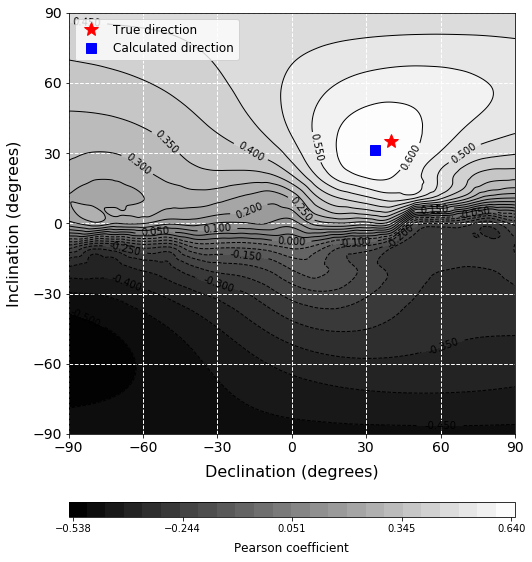

In [70]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 10))
c1 = pyplot.contour(Di.reshape(shapei), Ii.reshape(shapei), Res_both_i, 25, 
                    colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 10)
c2 = pyplot.contourf(Di.reshape(shapei), Ii.reshape(shapei), Res_both_i, 25, 
                     vmin = res_both.min(), vmax = res_both.max(), cmap = pyplot.cm.gray)
cbar = pyplot.colorbar(c2, aspect = 30, fraction = 0.1, orientation = 'horizontal', pad = 0.125)
cbar.set_label('Pearson coefficient', fontsize = 12, rotation = 0, labelpad = 8)
cbar.set_ticks(numpy.linspace(res_both_i.min(), res_both_i.max(), 5))
cbar.set_clim(res_both_i.min(), res_both_i.max())
pyplot.plot(decs, incs, 'r*', label = 'True direction', markersize = 14)
pyplot.plot(deci, inci, 'bs', label = 'Calculated direction', markersize = 10)
pyplot.xlabel('Declination (degrees)', fontsize = 16, labelpad = 10)
pyplot.ylabel('Inclination (degrees)', fontsize = 16, labelpad = 10)
pyplot.xticks(numpy.linspace(dec.min(), dec.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inc.min(), inc.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 1.)

pyplot.savefig('figure03-correlation.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure03-correlation.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [93]:
# Calculate the reduction to Pole
rtp_fd = reduction(xobs, yobs, dobs, incf, decf, incs, decs)
rtp_sd = rtp_layer(layerdata, shape, eqvlayer, shape_layer, 0.01, incf, decf, incs, decs)

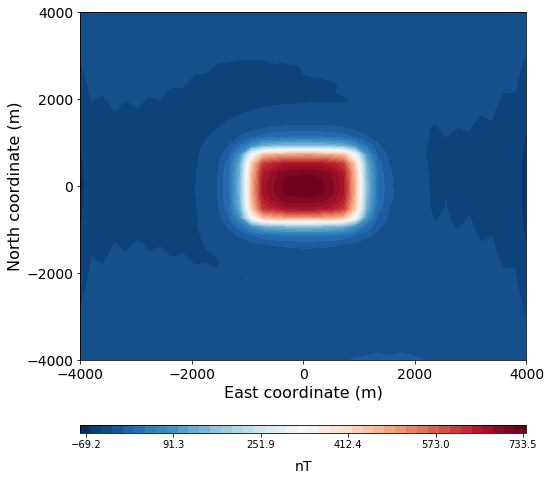

In [96]:
# Visualyzing the data plt
pyplot.close('all')
pyplot.figure(figsize=(8,8))
fig1 = pyplot.contourf(y.reshape(shape), x.reshape(shape), rtp_fd,
                       50, cmap = pyplot.cm.RdBu_r)
cbar1 = pyplot.colorbar(fig1, aspect = 60, fraction = 0.05, orientation = 'horizontal')
cbar1.set_label('nT', fontsize = 14, rotation = 0, labelpad = 10)
cbar1.set_ticks(numpy.linspace(rtp_fd.min(), rtp_fd.max(), 6))
cbar1.set_clim(rtp_fd.min(), rtp_fd.max())
pyplot.xlabel('East coordinate (m)', fontsize = 16)
pyplot.ylabel('North coordinate (m)', fontsize = 16)
pyplot.xticks(numpy.linspace(y.min(), y.max(), 5), fontsize = 14)
pyplot.yticks(numpy.linspace(x.min(), x.max(), 5), fontsize = 14)

pyplot.savefig('figure04-rtp.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure04-rtp.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

# 2 - Real data: Serra do Cabral magnetic anomaly

## (A) Plot the location map and magnetic anomaly

In [13]:
# Define the limits
longmin = longitude.min()
longmax = longitude.max()
latmin = latitude.min()
latmax = latitude.max()
long0 = 0.5*(longmin + longmax)
lat0 = 0.5*(latmin + latmax)

In [14]:
# Create the full basemap location
basemap = Basemap(llcrnrlon = -75., llcrnrlat = -35.,
                  urcrnrlon = -30., urcrnrlat = 5., 
                  resolution = 'f', projection = 'tmerc', 
                  epsg = 3395)

In [15]:
# Define meridians and parallels
meridians01 = numpy.linspace(0., 360., 19)
parallels01 = numpy.linspace(-90., 90., 19)

In [ ]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(10,10))
basemap.arcgisimage(service = 'NatGeo_World_Map', xpixels = 600, ypixels = 600, verbose= True)
basemap.drawmeridians(meridians01, labels=[1, 0, 0, 1], fontsize = 14)
basemap.drawparallels(parallels01, labels=[1, 0, 0, 1], fontsize = 14)
basemap.drawmapscale(-35., -33., longmax, latmax, 800, barstyle = 'simple')
basemap.plot((longmin, longmin, longmax, longmax, longmin), (latmin, latmax, latmax, latmin, latmin), 
          'r-', linewidth = 1.5, label = 'Study area', latlon = True)
pyplot.xlabel('Longitude $(^o)$', fontsize = 18, labelpad = 25)
pyplot.ylabel('Latitude $(^o)$', fontsize = 18, labelpad = 45)
pyplot.legend(loc = 'upper right', fontsize = 'x-large')
pyplot.savefig('figure05-location.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure05-location.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=-8348961.8095,-4139372.76225,-3339584.7238,553583.846816&bboxSR=3395&imageSR=3395&size=600,600&dpi=96&format=png32&f=image


In [18]:
# Create the simple basemap
cabralmap = Basemap(llcrnrlon = longmin - 0.1, llcrnrlat = latmin - 0.1,
                    urcrnrlon = longmax + 0.1, urcrnrlat = latmax + 0.1, 
                    resolution = 'f', projection = 'tmerc', 
                    lon_0 = long0, lat_0 = lat0, epsg = 3395)

In [19]:
# Define meridians and parallels
meridians02 = numpy.linspace(0., 360., 361)
parallels02 = numpy.linspace(-90., 90., 181)

http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=-5065036.83109,-2065111.30139,-4831265.90043,-1839034.34392&bboxSR=3395&imageSR=3395&size=600,600&dpi=96&format=png32&f=image


/home/nielsendelimar/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nielsendelimar/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


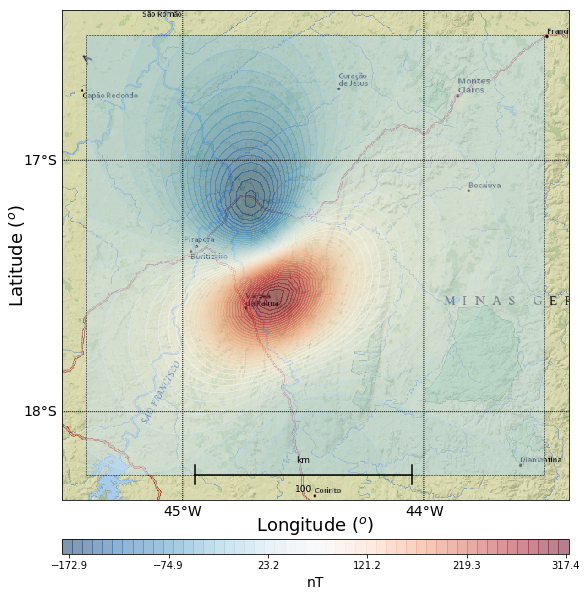

In [20]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(10,10))
cabralmap.arcgisimage(service = 'NatGeo_World_Map', xpixels = 600, ypixels = 600, verbose= True)
cs = cabralmap.contourf(longitude.reshape(shapedata), latitude.reshape(shapedata), tf.reshape(shapedata),
                 50, cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 0.5)
cbar = cabralmap.colorbar(cs, location = 'bottom', size = '3%', pad = '8%')
cbar.set_label('nT', fontsize = 14, rotation = 0, labelpad = 5)
cbar.set_ticks(numpy.linspace(tf.min(), tf.max(), 6))
cbar.set_clim(tf.min(), tf.max())
cabralmap.drawmeridians(meridians02, labels=[1, 0, 0, 1], fontsize = 14)
cabralmap.drawparallels(parallels02, labels=[1, 0, 0, 1], fontsize = 14)
cabralmap.drawmapscale(-44.5, -18.25, longmax, latmax, 100, barstyle = 'simple')
cabralmap.plot((longmin, longmin, longmax, longmax, longmin), 
               (latmin, latmax, latmax, latmin, latmin), 
               'k--', linewidth = 0.5, label = 'Study area', latlon = True)
pyplot.xlabel('Longitude $(^o)$', fontsize = 18, labelpad = 15)
pyplot.ylabel('Latitude $(^o)$', fontsize = 18, labelpad = 35)
pyplot.savefig('figure05-location.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure05-location.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

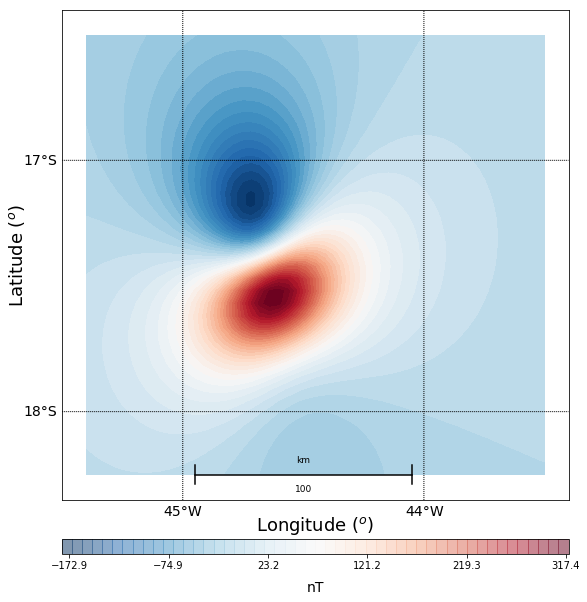

In [346]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(10,10))
cp = cabralmap.contourf(longitude.reshape(shapedata), latitude.reshape(shapedata), tf.reshape(shapedata),
                 50, cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = cabralmap.colorbar(cs, location = 'bottom', size = '3%', pad = '8%')
cbar.set_label('nT', fontsize = 14, rotation = 0, labelpad = 10)
cbar.set_ticks(numpy.linspace(tf.min(), tf.max(), 6))
cbar.set_clim(tf.min(), tf.max())
cabralmap.drawmeridians(meridians02, labels=[1, 0, 0, 1], fontsize = 14)
cabralmap.drawparallels(parallels02, labels=[1, 0, 0, 1], fontsize = 14)
cabralmap.drawmapscale(-44.5, -18.25, longmax, latmax, 100, barstyle = 'simple')
pyplot.xlabel('Longitude $(^o)$', fontsize = 18, labelpad = 15)
pyplot.ylabel('Latitude $(^o)$', fontsize = 18, labelpad = 35)
pyplot.savefig('figure06-location.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure06-location.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

## (B) Compute cross-correlation in Fourier domain

In [233]:
# Analyze magnetic total field data
_ = analysis(tf, 'nT')

Minimum:    -172.9280 nT
Maximum:    317.3630 nT
Mean value: 10.0603 nT
Variation:  490.2910 nT


In [273]:
# Reshape the data 
Xo = xo.reshape(shapedata)
Yo = yo.reshape(shapedata)
Zo = -100.*numpy.ones(shapedata)
TF = tf.reshape(shapedata)

In [337]:
# Field direction (Ussami, 1981; Ponte-Neto, 2008)
Incf, Decf = -17., -17.5
incIGRF, decIGRF, Field = numpy.loadtxt('igrf.csv', usecols = (1, 2, 4), delimiter=',', unpack = True)

In [338]:
# Define the mean values
#Incf = incIGRF.mean()
#Decf = decIGRF.mean()
print 'Field inclination: %.1f' % Incf
print 'Field declination: %.1f' % Decf

Field inclination: -17.0
Field declination: -17.5


In [339]:
# Create the grids
inclination1 = numpy.linspace(15., 90., 76)
declination1 = numpy.linspace(-180., 180., 361)
Dec1, Inc1 = numpy.meshgrid(declination1, inclination1)

In [340]:
# Create the zero matrix
cc_fd = numpy.zeros_like(Dec1)

In [341]:
# Compute the calculation time
timei = time()
for k, d in enumerate(declination1):
    for j, i in enumerate(inclination1):
        rtp = reduction(Yo, Xo, TF, Incf, Decf, i, d)
        cc_fd[j,k] = cccoef(totalgrad(Yo, Xo, rtp),
                            zderiv(Yo, Xo, rtp))
timef = time()
print 'Calculation time: %.3f' % (timef - timei) 

Calculation time: 75.835


In [342]:
# Search the maximum
Imax, Jmax = numpy.where(cc_fd == cc_fd.max())
inc1_cc = Inc1[Imax, Jmax]
dec1_cc = Dec1[Imax, Jmax]
print 'Directions: %.1f %.1f' % (inc1_cc, dec1_cc)

Directions: 19.0 162.0


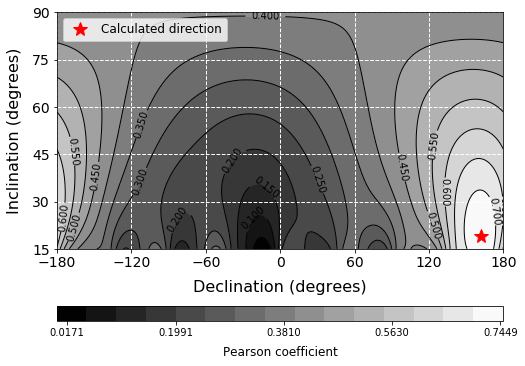

In [343]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 6))
c1 = pyplot.contour(Dec1, Inc1, cc_fd, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 10)
c2 = pyplot.contourf(Dec1, Inc1, cc_fd, 15, vmin = cc_fd.min(), vmax = cc_fd.max(), cmap = pyplot.cm.gray)
cbar = pyplot.colorbar(c2, aspect = 30, fraction = 0.1, orientation = 'horizontal', pad = 0.175)
cbar.set_label('Pearson coefficient', fontsize = 12, rotation = 0., labelpad = 8)
cbar.set_ticks(numpy.linspace(cc_fd.min(), cc_fd.max(), 5))
cbar.set_clim(cc_fd.min(), cc_fd.max())
pyplot.plot(dec1_cc, inc1_cc, 'r*', label = 'Calculated direction', markersize = 14)
pyplot.xlabel('Declination (degrees)', fontsize = 16, labelpad = 10)
pyplot.ylabel('Inclination (degrees)', fontsize = 16, labelpad = 10)
pyplot.xticks(numpy.linspace(Dec1.min(), Dec1.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Inc1.min(), Inc1.max(), 6), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 1.)

pyplot.savefig('figure07-correlation.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure07-correlation.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [344]:
# Calculate the reduction to Pole
Rtp_fd = reduction(Yo, Xo, TF, Incf, Decf, inc1_cc, dec1_cc)

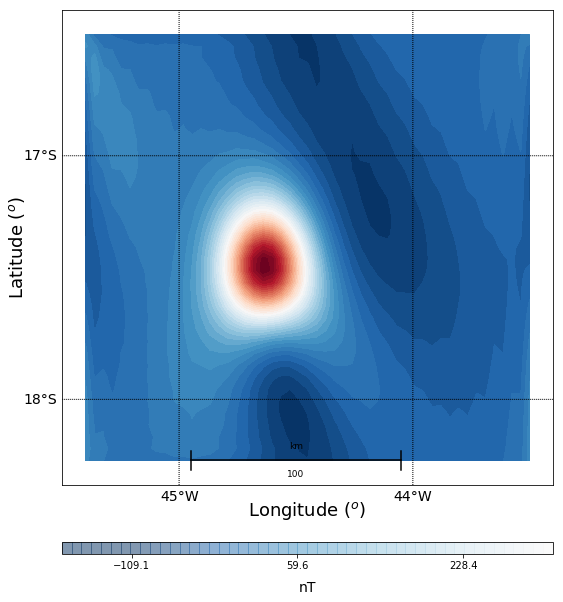

In [345]:
# Plotting the reduced data
pyplot.close('all')
pyplot.figure(figsize=(10,10))
cp = cabralmap.contourf(longitude.reshape(shapedata), latitude.reshape(shapedata), Rtp_fd,
                 50, cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = cabralmap.colorbar(cs, location = 'bottom', size = '2.5%', pad = '12%')
cbar.set_label('nT', fontsize = 14, rotation = 0, labelpad = 10)
cbar.set_ticks(numpy.linspace(Rtp_fd.min(), Rtp_fd.max(), 6))
cbar.set_clim(Rtp_fd.min(), Rtp_fd.max())
cabralmap.drawmeridians(meridians02, labels=[1, 0, 0, 1], fontsize = 14)
cabralmap.drawparallels(parallels02, labels=[1, 0, 0, 1], fontsize = 14)
cabralmap.drawmapscale(-44.5, -18.25, longmax, latmax, 100, barstyle = 'simple')
pyplot.xlabel('Longitude $(^o)$', fontsize = 18, labelpad = 15)
pyplot.ylabel('Latitude $(^o)$', fontsize = 18, labelpad = 35)
pyplot.savefig('figure08-rtp.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure08-rtp.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

## (C) Compute cross-correlation in space domain

In [412]:
# Build the layer
AreaL = (xo.min(), xo.max(), yo.min(), yo.max())
ShapeL = (40, 40)
Level = 500.
EQL = layer(AreaL, ShapeL, Level)

In [413]:
# Observation level
zo = -250.*numpy.ones_like(tf)

In [414]:
# All data
Data = [xo, yo, zo, tf]

In [354]:
# Direction vectors
inclination2 = numpy.linspace(-90., 90., 19)
declination2 = numpy.linspace(-180., 180., 19)
Dec2, Inc2 = numpy.meshgrid(declination2, inclination2)

In [356]:
# Zero 2D array
cc_sd = numpy.zeros_like(Dec2)

In [357]:
# Compute the calculation time
timei = time()
for k, d in enumerate(declination2):
    for j, i in enumerate(inclination2):
        if i >= -20. or i <= 20.:
            rtp = rtp_layer(Data, shapedata, EQL, ShapeL, 0.01, Incf, Decf, i, d)
            cc_sd[j,k] = cccoef(totalgrad(Yo, Xo, rtp),
                                zderiv(Yo, Xo, rtp))
        else:
            rtp = reduction(xobs, yobs, dobs, Incf, Decf, i, d)
            cc_sd[j,k] = cccoef(totalgrad(Yo, Xo, rtp),
                                   zderiv(Yo, Xo, rtp))
timef = time()
print 'Calculation time: %.3f' % (timef - timei)        

Calculation time: 123.302


In [361]:
# Interpolate the calculated data
Areai = (-90., 90., -180., 180.)
Shapei = (361, 361)
INCi, DECi = regular_grid(Areai, Shapei)
result = griddata((Inc2.reshape(Inc2.size), Dec2.reshape(Dec2.size)),
                  cc_sd.reshape(cc_sd.size), (INCi, DECi), method = 'cubic')
Result = result.reshape(Shapei)

In [362]:
# Searchinf the maximum coefficient
row, col = numpy.where(Result == Result.max())
Inc_real = float(INCi.reshape(Shapei)[row, col])
Dec_real = float(DECi.reshape(Shapei)[row, col])
print 'Direction: % .1f % .1f' % (Inc_real, Dec_real)

Direction: -48.5 -145.0


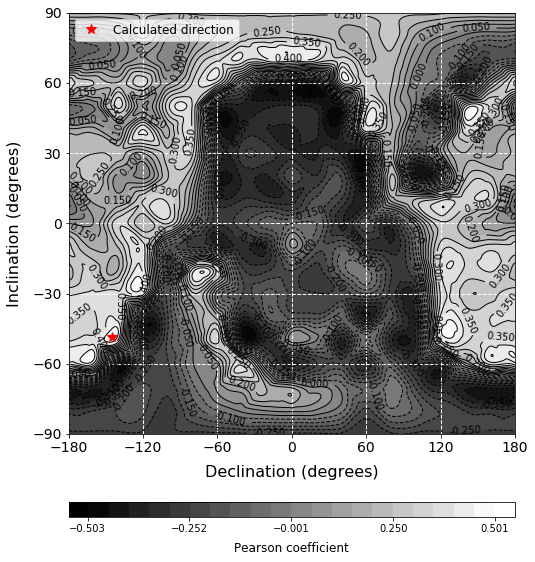

In [422]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 10))
c1 = pyplot.contour(DECi.reshape(Shapei), INCi.reshape(Shapei), Result, 20, 
                    colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 10)
c2 = pyplot.contourf(DECi.reshape(Shapei), INCi.reshape(Shapei), Result, 20, 
                     vmin = Result.min(), vmax = Result.max(), cmap = pyplot.cm.gray)
cbar = pyplot.colorbar(c2, aspect = 30, fraction = 0.1, orientation = 'horizontal', pad = 0.125)
cbar.set_label('Pearson coefficient', fontsize = 12, rotation = 0, labelpad = 8)
cbar.set_ticks(numpy.linspace(Result.min(), Result.max(), 5))
cbar.set_clim(Result.min(), Result.max())
pyplot.plot(Dec_real, Inc_real, 'r*', label = 'Calculated direction', markersize = 10)
pyplot.xlabel('Declination (degrees)', fontsize = 16, labelpad = 10)
pyplot.ylabel('Inclination (degrees)', fontsize = 16, labelpad = 10)
pyplot.xticks(numpy.linspace(declination2.min(), declination2.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inclination2.min(), inclination2.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 1.)

pyplot.savefig('figure09-correlation.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure09-correlation.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [417]:
# Calculate the reduction to Pole
Rtp_sd = rtp_layer(Data, shapedata, EQL, ShapeL, 0.01, Inc_real, Dec_real, incs, decs)

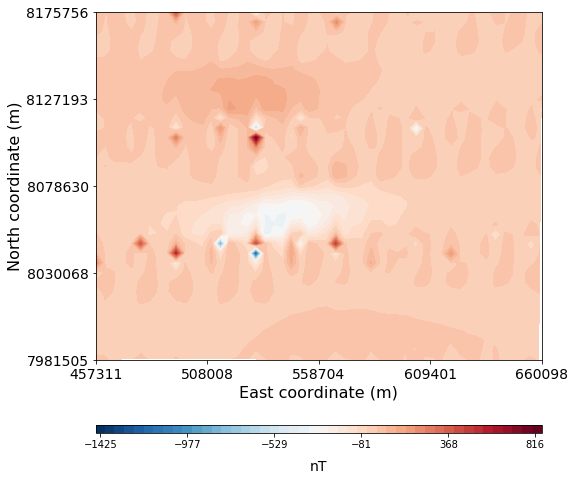

In [421]:
# Visualyzing the data plt
pyplot.close('all')
pyplot.figure(figsize=(8,8))
fig1 = pyplot.contourf(xo.reshape(shapedata), yo.reshape(shapedata), Rtp_sd,
                       50, cmap = pyplot.cm.RdBu_r)
cbar1 = pyplot.colorbar(fig1, aspect = 60, fraction = 0.05, orientation = 'horizontal')
cbar1.set_label('nT', fontsize = 14, rotation = 0, labelpad = 10)
cbar1.set_ticks(numpy.linspace(Rtp_sd.min(), Rtp_sd.max(), 6))
cbar1.set_clim(Rtp_sd.min(), Rtp_sd.max())
pyplot.xlabel('East coordinate (m)', fontsize = 16)
pyplot.ylabel('North coordinate (m)', fontsize = 16)
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 14)
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 14)
pyplot.savefig('figure10-rtp.png', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.savefig('figure10-rtp.pdf', dpi = 600, transparent = True, bbox_inches = 'tight')
pyplot.show()